In [30]:
import mailcom.inout
import mailcom.parse
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import mailcom.utils

In [31]:
# create t0 timestamp
t0 = time.time()

In [32]:
out_file = "../data/out/lang_detection_from_csv.csv"
# import files from csv file
email_list = pd.read_csv("../mailcom/test/data_extended/mails_lb_sg.csv")
print(email_list)

t_csv_read = time.time()

# create pseudonymization object
ps = mailcom.parse.Pseudonymize()
ps.init_spacy("fr")
ps.init_transformers()
ld = mailcom.utils.LangDetector()
ld.init_transformers()
# time stamp after model loading
t_model_loaded = time.time()

     Unnamed: 0                                            message
0           242  Von meinem iPhone gesendet Anfang der weiterge...
1           243  Von meinem iPhone gesendet Anfang der weiterge...
2           244  Von meinem iPhone gesendet Anfang der weiterge...
3           245  Von meinem iPhone gesendet Anfang der weiterge...
4           246  Von meinem iPhone gesendet Anfang der weiterge...
..          ...                                                ...
98         1313  \nVon: Mélissa des Presses de l'Université Lav...
99         1314  Von: Librairie Classiques Garnier &amp;lt;libr...
100        1315  La langue s'enrichit #36 - FranceTerme\nProf. ...
101        1316  Activités de juin - Presses de l'Université La...
102        1317  Nouveautés de juin\nProf. Dr. Sybille Große I ...

[103 rows x 2 columns]


Some weights of the model checkpoint at xlm-roberta-large-finetuned-conll03-english were not used when initializing XLMRobertaForTokenClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0
Device set to use cuda:0


In [37]:
# loop over mails and detect their languages
lang_out_list = []
lang_ts_list = []
for idx, row in email_list.iterrows():
    ts_email_start = time.time()
    text = row["message"]
    email_dict = {"content": text}
    if not text:
        continue
    # Test functionality of LangDetector class
    ts_email_ppr_done = time.time()
    for lang_lib in ["langid", "langdetect", "trans"]:
        det_lang = ld.get_detections(text, lang_lib)
        email_dict[lang_lib] = "{}-{}".format(det_lang[0][0], det_lang[0][1])

    lang_out_list.append(email_dict)

    # timestamp after this email
    ts_email_end = time.time()
    lang_ts_list.append([ts_email_start, ts_email_ppr_done, ts_email_end])

In [38]:
# write output to pandas df
df = pd.DataFrame(lang_out_list)
print(df)

                                               content  langid  \
0    Von meinem iPhone gesendet Anfang der weiterge...  fr-1.0   
1    Von meinem iPhone gesendet Anfang der weiterge...  fr-1.0   
2    Von meinem iPhone gesendet Anfang der weiterge...  fr-1.0   
3    Von meinem iPhone gesendet Anfang der weiterge...  fr-1.0   
4    Von meinem iPhone gesendet Anfang der weiterge...  fr-1.0   
..                                                 ...     ...   
98   \nVon: Mélissa des Presses de l'Université Lav...  fr-1.0   
99   Von: Librairie Classiques Garnier &amp;lt;libr...  fr-1.0   
100  La langue s'enrichit #36 - FranceTerme\nProf. ...  fr-1.0   
101  Activités de juin - Presses de l'Université La...  fr-1.0   
102  Nouveautés de juin\nProf. Dr. Sybille Große I ...  fr-1.0   

                langdetect                  trans  
0     fr-0.999997643017964  fr-0.9911757707595825  
1    fr-0.9999985698658455  fr-0.9899152517318726  
2     fr-0.999996534677391  fr-0.9927849769592285  

In [39]:
# store the results in a csv file
df.to_csv(out_file, index=False)

In [41]:
for item in df["trans"][90:104]:
    print(item)

fr-0.9913384914398193
fr-0.9913080334663391
fr-0.9910556077957153
fr-0.9912301301956177
fr-0.9908391833305359
fr-0.9915818572044373
fr-0.9918330907821655
fr-0.9908162355422974
fr-0.9911774396896362
fr-0.990962564945221
fr-0.9920682907104492
fr-0.9914606809616089
fr-0.9915869235992432


In [5]:
# loop over mails and pseudonymize them
out_list = []
ts_list = []
for idx, row in email_list.iterrows():
    ts_email_start = time.time()
    text = row["message"]
    email_dict = {"content": text}
    if not text:
        continue
    # Test functionality of Pseudonymize class
    # Pseudonymization is usually done using ps.pseudonymize
    # For performance analysis the process is split into its subprocesses here
    ps.reset()
    sentences = ps.get_sentences(text)
    ts_email_ppr_done = time.time()
    pseudonymized_sentences = []
    for sent in sentences:
        sent = ps.pseudonymize_email_addresses(sent)
        ner = ps.get_ner(sent)
        ps_sent = " ".join(ps.pseudonymize_ne(ner, sent)) if ner else sent
        ps_sent = ps.pseudonymize_numbers(ps_sent)
        pseudonymized_sentences.append(ps_sent)
    output_text = ps.concatenate(pseudonymized_sentences)

    # add output to dict
    email_dict["pseudo_content"] = output_text
    out_list.append(email_dict)

    # timestamp after this email
    ts_email_end = time.time()
    ts_list.append([ts_email_start, ts_email_ppr_done, ts_email_end])

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [11]:
# write output to pandas df
df = pd.DataFrame(out_list)
print(df)

                                               content  \
0    Von meinem iPhone gesendet Anfang der weiterge...   
1    Von meinem iPhone gesendet Anfang der weiterge...   
2    Von meinem iPhone gesendet Anfang der weiterge...   
3    Von meinem iPhone gesendet Anfang der weiterge...   
4    Von meinem iPhone gesendet Anfang der weiterge...   
..                                                 ...   
98   \nVon: Mélissa des Presses de l'Université Lav...   
99   Von: Librairie Classiques Garnier &amp;lt;libr...   
100  La langue s'enrichit #36 - FranceTerme\nProf. ...   
101  Activités de juin - Presses de l'Université La...   
102  Nouveautés de juin\nProf. Dr. Sybille Große I ...   

                                              det_lang  
0    [(fr, 0.9911757707595825), (ru, 0.000684742582...  
1    [(fr, 0.9899152517318726), (ru, 0.000784482806...  
2    [(fr, 0.9927849769592285), (tr, 0.000568731455...  
3    [(fr, 0.9916396737098694), (ru, 0.000675349729...  
4    [(fr, 0.98492

Total time: 00:10


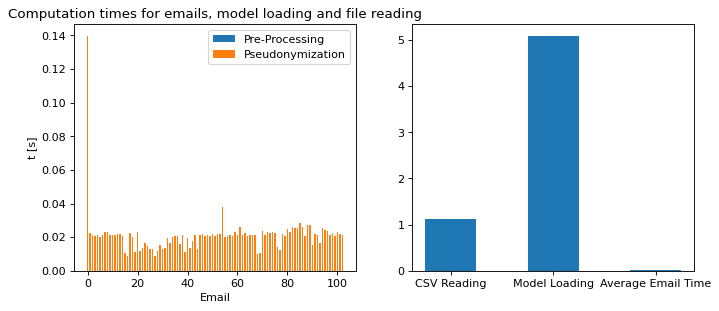

In [12]:
# display timestamps

# bar plot for each individual email
# processing times
idx_list = [row[0] for row in email_list.iterrows()]
email_duration_list = [ts[2] - ts[1] for ts in ts_list]
email_ppr_list = [ts[1] - ts[0] for ts in ts_list]
email_total_list = [ts[2] - ts[0] for ts in ts_list]
email_bar_height = {
    "Pre-Processing": email_ppr_list,
    "Pseudonymization": email_duration_list
}
bt = [0 for idx in idx_list]

plt.figure(figsize=(10,4), dpi=80)

# plot 1
plt.subplot(1, 2, 1)
for key, height in email_bar_height.items():
    plt.bar(idx_list, height, 0.5, label=key, bottom=bt)
    bt = [bi + hi for (bi,hi) in zip(bt, height)]
#plt.yscale("log")
plt.xlabel("Email")
plt.ylabel("t [s]")
plt.title("Computation times for emails, model loading and file reading")
plt.legend()

# plot for model loading and file reading, as well as average email time
# processing times
bar_x = ["CSV Reading", "Model Loading", "Average Email Time"]
average_email_time = sum(email_total_list) / len(email_total_list)
bar_y = [t_csv_read - t0, t_model_loaded - t0, average_email_time]
plt.ylabel("t [s]")

# plot 2
plt.subplot(1, 2, 2)
plt.bar(bar_x, bar_y, 0.5)

# Total time
print("Total time:", (datetime.datetime.fromtimestamp(ts_list[len(ts_list)-1][2] - t_model_loaded).strftime('%M:%S')))